In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

## Degree histogramm

In [2]:
# Degree histogram
data = [
    [4, 634, 142, 17, 2],
    [698, 2209024, 1024223, 132039, 33149],
    [172, 1047747, 1276439, 144943, 39048],
    [15, 136996, 147076, 41829, 15648],
    [5, 34487, 40695, 16039, 10937]
]
data_array = np.array(data)
normalized_data = data_array / data_array.max()

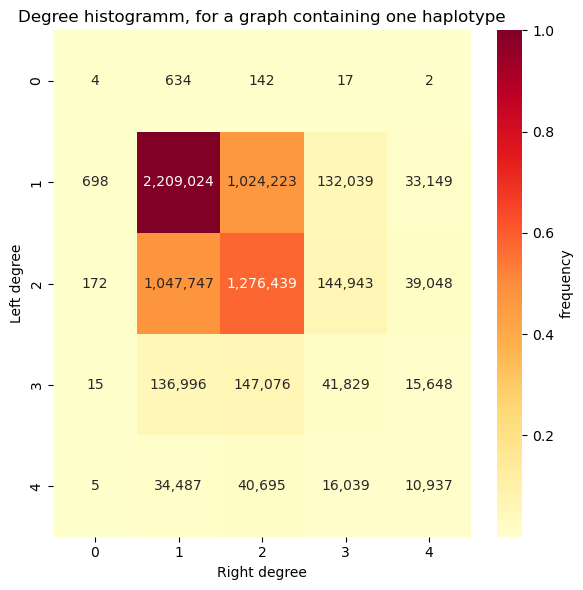

In [3]:
plt.figure(figsize=(6,6))
ax = sns.heatmap(
    normalized_data, 
    annot=data_array,  # Show the original values as annotations
    fmt=",",           # Format annotations with commas for readability
    cmap="YlOrRd",     # Yellow-Orange-Red color map
    cbar_kws={'label': 'frequency'}
)
plt.title('Degree histogramm, for a graph containing one haplotype')
plt.xlabel('Right degree')
plt.ylabel('Left degree')
plt.tight_layout()

In [ ]:
def parse_checkpoints(fasta_file):
    nb_unitigs = []
    start_pos = []
    
    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                continue
            elif line:
                line = line.split(":", 1)[0]
                line_parts = line.split()
                nb_unitigs.append(int(line_parts[0]))
                start_pos.append(int(line_parts[-1]))
    
    return nb_unitigs, start_pos

# TODO: ceci est faux, le motif trouvé n'est pas forcément le plus long (cf path.rs pour l'algo)
def get_repeats(file, max_size_pattern=3, min_nb_patterns=3):
    is_repeat = []
    
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            # Initialize the deque and repeat counts when a new header is found
            if line.startswith('>'):
                nb_patterns = [0 for _ in range(max_size_pattern)]
                line_history = deque(maxlen=max_size_pattern)
            elif line:
                is_repeat.append(False)
                _, line_nodes = line.split(":", 1)
                for size in range(1, max_size_pattern+1):
                    # If the current line matches a previous one: increase pattern count
                    if len(line_history) >= size and line_nodes == line_history[-size]:
                        nb_patterns[size-1] += 1
                    else:
                        # if pattern was repeated enough times, mark concerned lines as repeat
                        if size+nb_patterns[size-1] >= size*min_nb_patterns:
                            for i in range(size+nb_patterns[size-1]):
                                is_repeat[-(i+1)] = True
                            nb_patterns = [0 for _ in range(max_size_pattern)]
                            break
                        nb_patterns[size-1] = 0
                line_history.append(line_nodes)
    return is_repeat

In [5]:
path_hap_1 = "output/chr1/checkpoints_AalbF5_in_1.fna"
path_hap_2 = "output/chr1/checkpoints_AalbF5_in_2.fna"

nb_unitigs_1_hap, start_pos_1_hap = parse_checkpoints(path_hap_1)
nb_unitigs_2_hap, start_pos_2_hap = parse_checkpoints(path_hap_2)

repeats_1 = get_repeats(path_hap_1, max_size_pattern=3, min_nb_patterns=3)
repeats_2 = get_repeats(path_hap_2, max_size_pattern=3, min_nb_patterns=3)

In [6]:
path_stats_1 = "output/chr1/stats_checkpoints_AalbF5_in_1.fna"
path_stats_2 = "output/chr1/stats_checkpoints_AalbF5_in_2.fna"

df_1 = pd.read_csv(path_stats_1, sep='\t', header=None, comment='>', names=['unitigs', 'breakpoints_left', 'breakpoints_right'])
df_2 = pd.read_csv(path_stats_2, sep='\t', header=None, comment='>', names=['unitigs', 'breakpoints_left', 'breakpoints_right'])

In [7]:
df_1['is_repeat'] = repeats_1
df_1['start_pos'] = start_pos_1_hap

df_2['is_repeat'] = repeats_2
df_2['start_pos'] = start_pos_2_hap

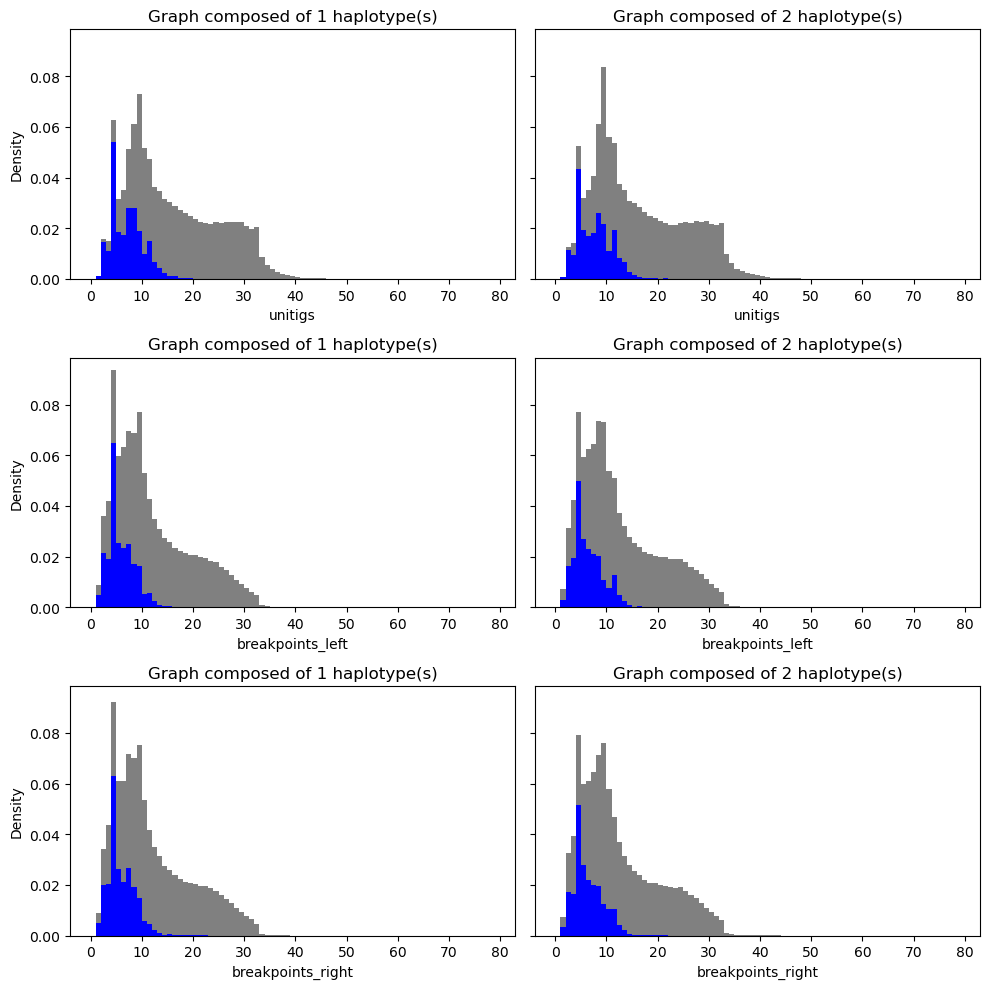

In [8]:
bins = np.arange(0, 80, 1)

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
dfs = [df_1, df_2]

for i in range(2):
    df = dfs[i]

    for j, column in enumerate(['unitigs', 'breakpoints_left', 'breakpoints_right']):

        repeated = df[df['is_repeat'] == True][column]
        not_repeated = df[df['is_repeat'] == False][column]
        
        axes[j,i].hist([repeated, not_repeated], bins=bins, stacked=True, 
                label=['Repeated', 'Not Repeated'],
                color=['blue', 'grey'], density=True)
        axes[j,i].set_title(f'Graph composed of {i+1} haplotype(s)')
        axes[j,i].set_xlabel(column)
        axes[j,0].set_ylabel('Density')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [9]:
# graph with 1 haplo (only AalbF5, k=31)
nb_nodes_graph = 6_352_008
nb_edges_graph = 9_827_475
degree_histogramm = [4, 1332, 2209338, 2072002, 1545481, 359655, 121572, 31687, 10937]

# haplo AalbF5 within this graph
nb_unitigs_haplo = 61_051_497
nb_kmers_haplo = 337_698_822
breakpoints = [46619297, 862]   # (right out degree >1 / <1)
mean_unitigs_per_checkpoint = df_1['unitigs'].mean()    # 15.333052192604827

In [10]:
# graph with 2 haplos (AalbF3+AalbF5, k=31)
nb_nodes_graph = 12_765_875
nb_edges_graph = 19_677_364
degree_histogramm = [1, 1082, 4633135, 3959082, 3124324, 697889, 255900, 67707, 26755]

# haplo AalbF5 within this graph
nb_unitigs_haplo = 71_134_451
nb_kmers_haplo = 337_698_822
breakpoints = [55574509, 470]   # (right out degree >1 / <1)
mean_unitigs_per_checkpoint = df_2['unitigs'].mean()    # 15.63696158313586

In [11]:
# start node (relative to the previous end one) + end node id + end node orientation
bits_per_checkpoint =  2 + math.ceil(math.log2(nb_nodes_graph)) + 1
bits_per_checkpoint # 27

27

In [12]:
bits_total = bits_per_checkpoint * nb_unitigs_haplo / mean_unitigs_per_checkpoint
int(bits_total)   # 123 Mb

122826302

### BFS frontier size

In [13]:
path_histo_1 = "output/chr1/histo_graph1.txt"

In [14]:
df = pd.read_csv(path_histo_1, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2,1,2,1,2,1,2,1,1,2,...,5,4,8,9,12,22,27,37,47,76
1,2,3,5,6,11,20,29,55,81,120,...,559,733,978,1416,2118,3286,5218,8109,12556,19371
2,1,2,3,2,5,7,12,24,42,68,...,13432,19781,29755,45273,69747,107363,165156,250139,373157,543164
3,2,2,4,6,9,14,29,48,75,122,...,4874,7595,12001,19016,30123,47157,73553,113441,172565,258277
4,2,1,2,1,2,1,1,2,3,3,...,3,3,1,2,1,2,3,5,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,2,4,5,5,6,9,10,12,19,...,615,861,1248,1787,2506,3548,5120,7389,10673,15621
96,1,2,1,2,1,2,1,2,1,2,...,365,541,803,1163,1564,2056,2735,3722,5062,7209
97,1,3,2,3,5,10,13,23,34,52,...,813,1216,1877,2937,4510,7051,10894,16621,25228,38362
98,2,2,4,7,15,29,49,80,136,247,...,72808,116617,183793,283728,426914,622371,873716,1172599,1495637,1796536


Fitted parameter a: 1.547660248267524


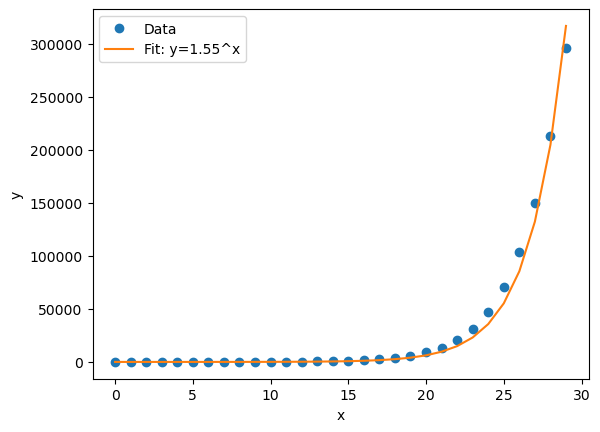

In [17]:
from scipy.optimize import curve_fit

# Define the function y = a^x
def exponential_func(x, a):
    return a ** x

# Calculate the mean of the dataframe
x_data = df.columns.astype(int)  # Assuming columns are integers representing x
y_data = df.mean().values        # Mean values for y

# Fit the data
params, _ = curve_fit(exponential_func, x_data, y_data)

# Extract the fitted parameter 'a'
a = params[0]
print(f"Fitted parameter a: {a}")

# Plot the original data and the fitted curve
plt.plot(x_data, y_data, 'o', label='Data')
plt.plot(x_data, exponential_func(x_data, a), '-', label=f'Fit: y={a:.2f}^x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()